# 1. Setup and Imports


In [2]:
import torch
import numpy as np
import pandas as pd
import os
import json
import sys
sys.path.append("../src")

from config import SEEDS, MODELS_DIR_TEMPORAL
from data_utils_temporal import load_and_preprocess_elliptic_temporal
from train_temporal import train_and_evaluate_temporal
from evaluation_multiseed import full_evaluation_report, visualize_mean_confusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("All modules imported successfully.")

All modules imported successfully.


# 2. Load and Preprocess Data

In [3]:
data, node_times = load_and_preprocess_elliptic_temporal()

# Move data to device (GPU or CPU)
data = data.to(device)

print(data)
print(f"Feature shape: {data.x.shape}")
print(f"Total labeled nodes: {(data.y != -1).sum().item()}")


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])
Feature shape: torch.Size([203769, 166])
Total labeled nodes: 46564


# 3. Initialize the GCN Model


In [ ]:
from model_gcn import GCNNet

# Hyperparameters
hidden_channels = 64
dropout = 0.3
out_channels = 2
in_channels = data.x.shape[1]

# Model initialization
model = GCNNet(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    dropout=dropout
).to(device)

print(model)

GCNNet(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 2)
)


## 4. Temporal Multiseed Training

In [5]:
from train_temporal import train_and_evaluate_temporal
from config import SEEDS

for seed in SEEDS:
    print(f"Running seed {seed}...")
    train_and_evaluate_temporal(seed, data, node_times, model_type="GCN")

Running seed 42...
Epoch 001 | Loss: 2.0937 | Val Acc: 0.3152 | Val F1: 0.2712
Epoch 002 | Loss: 1.9737 | Val Acc: 0.3315 | Val F1: 0.2843
Epoch 003 | Loss: 1.8855 | Val Acc: 0.3504 | Val F1: 0.2986
Epoch 004 | Loss: 1.4660 | Val Acc: 0.3800 | Val F1: 0.3189
Epoch 005 | Loss: 1.3491 | Val Acc: 0.4161 | Val F1: 0.3435
Epoch 006 | Loss: 0.8759 | Val Acc: 0.4569 | Val F1: 0.3698
Epoch 007 | Loss: 0.8722 | Val Acc: 0.5004 | Val F1: 0.3976
Epoch 008 | Loss: 0.6485 | Val Acc: 0.5367 | Val F1: 0.4193
Epoch 009 | Loss: 0.5410 | Val Acc: 0.5674 | Val F1: 0.4371
Epoch 010 | Loss: 0.4444 | Val Acc: 0.5963 | Val F1: 0.4537
Epoch 011 | Loss: 0.3903 | Val Acc: 0.6230 | Val F1: 0.4682
Epoch 012 | Loss: 0.3640 | Val Acc: 0.6473 | Val F1: 0.4817
Epoch 013 | Loss: 0.3264 | Val Acc: 0.6727 | Val F1: 0.4950
Epoch 014 | Loss: 0.3522 | Val Acc: 0.6948 | Val F1: 0.5065
Epoch 015 | Loss: 0.2924 | Val Acc: 0.7158 | Val F1: 0.5174
Epoch 016 | Loss: 0.2820 | Val Acc: 0.7340 | Val F1: 0.5278
Epoch 017 | Loss: 0.2

## 5. Evaluation and Visualisation

### 5.1 Import and Setup

In [1]:
import sys
sys.path.append("../src")

from evaluation_pipeline import (
    run_inference_all_seeds,
    plot_conf_matrices,
    summarize_classification_report,
    save_fp_fn_indices,
    attach_node_times,
    plot_fp_fn_time_distributions
)

from analysis_utils import (
    load_metrics_across_seeds,
    aggregate_metrics_table,
    plot_loss_curve
)

from model_gcn import GCNNet
from load_elliptic_data import load_and_preprocess_elliptic_data

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seeds = [42, 123, 777, 2023, 31415]

# Load model + data
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset").to(device)
model_class = GCNNet
model_dir = "../model_temporal/GCN"
model_name = "GCN-Temporal"

### 5.2 Load Metrics and Loss Curve

In [2]:
import os
import numpy as np

model_dir = "../model_temporal/GCN"  # Change if needed
seeds = [42, 123, 777, 2023, 31415]

print("Loss array length per seed:")

for seed in seeds:
    path = os.path.join(model_dir, f"seed_{seed}", "loss.npy")
    if os.path.exists(path):
        loss_array = np.load(path)
        print(f"Seed {seed}: {len(loss_array)} epochs")
    else:
        print(f"Seed {seed}: ❌ loss.npy not found")

Loss array length per seed:
Seed 42: 286 epochs
Seed 123: 300 epochs
Seed 777: 300 epochs
Seed 2023: 300 epochs
Seed 31415: 300 epochs


,Metric,Mean,Std,Formatted
0,val_acc,0.9518,0.0009,0.9518 ± 0.0009
1,val_f1_macro,0.7139,0.0058,0.7139 ± 0.0058
2,val_f1_illicit,0.9748,0.0005,0.9748 ± 0.0005


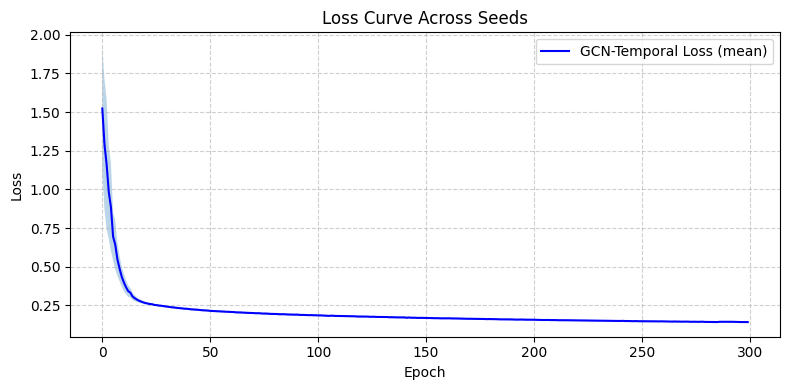

In [3]:
metrics_logs = load_metrics_across_seeds(model_dir, ["val_acc", "val_f1_macro", "val_f1_illicit", "loss"])
summary_df = aggregate_metrics_table(metrics_logs)
display(summary_df)
plot_loss_curve(metrics_logs["loss"], label=model_name + " Loss")

### 5.3 Inference Across Seeds

In [4]:
y_true_all, y_pred_all, y_proba_all, seed_metrics = run_inference_all_seeds(
    model_dir=model_dir,
    model_class=model_class,
    data=data,
    seeds=seeds
)

### 5.4 Confusion Matrices

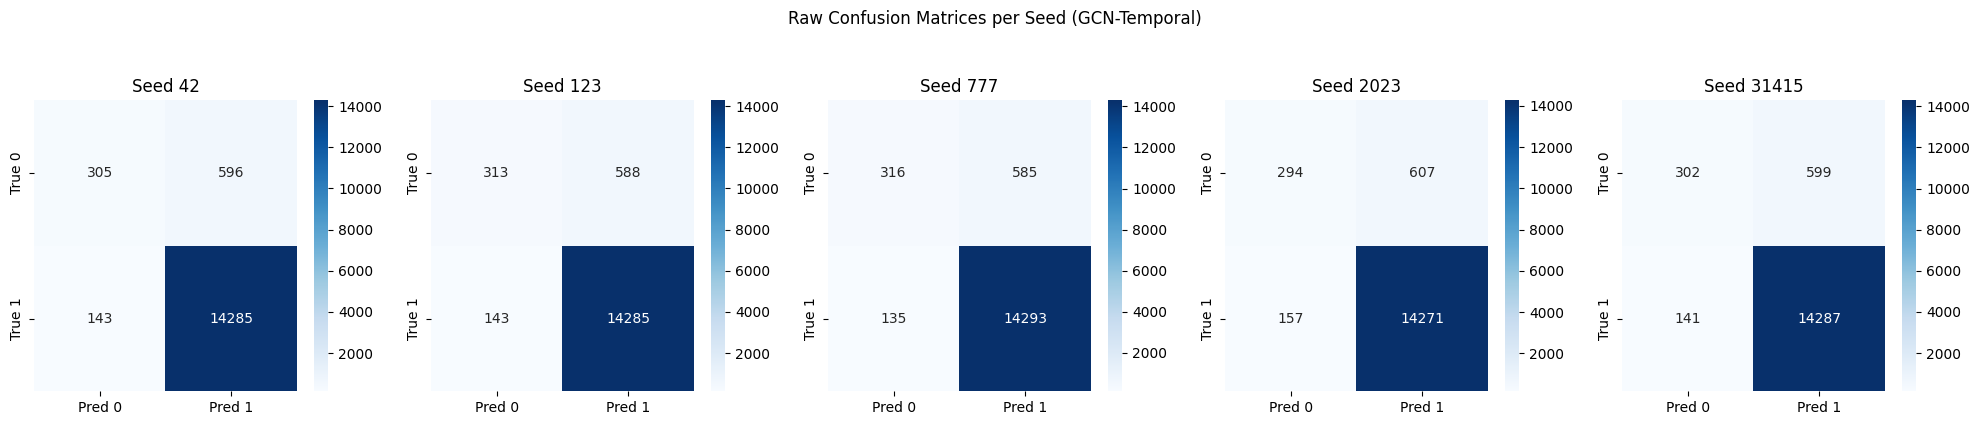

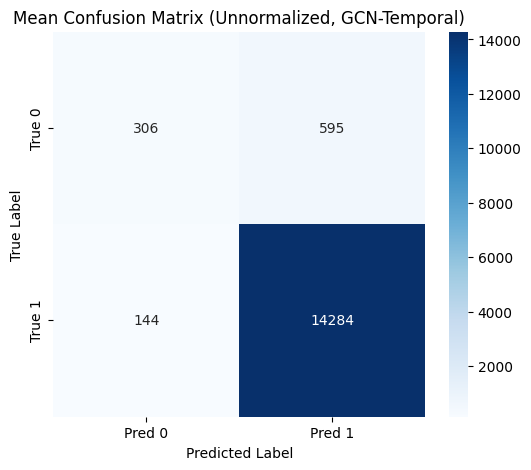

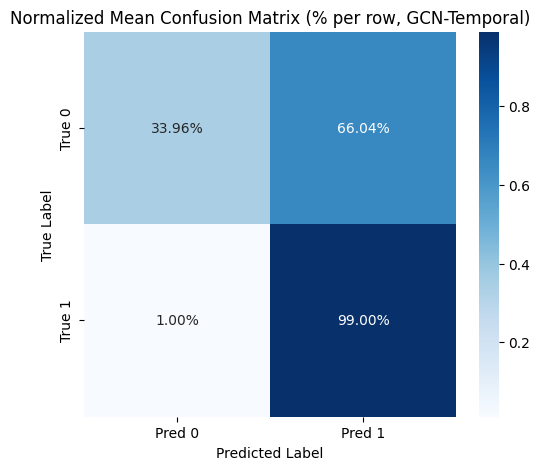

In [5]:
plot_conf_matrices(y_true_all, y_pred_all, seeds, model_name=model_name)

### 5.5 Metric Summary

In [6]:
for i, m in enumerate(seed_metrics):
    print(f"Seed {seeds[i]} → MCC: {m.get('mcc')}, type: {type(m.get('mcc'))}")


Seed 42 → MCC: 0.45885969496931867, type: <class 'numpy.float64'>
Seed 123 → MCC: 0.46723185027663444, type: <class 'numpy.float64'>
Seed 777 → MCC: 0.4751419926554393, type: <class 'numpy.float64'>
Seed 2023 → MCC: 0.43903340560218906, type: <class 'numpy.float64'>
Seed 31415 → MCC: 0.4568841669844114, type: <class 'numpy.float64'>


Final columns: ['accuracy', 'f1_macro', 'f1_illicit', 'precision_illicit', 'recall_illicit', 'bal_acc', 'mcc', 'roc_auc_macro', 'pr_auc_illicit', 'specificity', 'fpr', 'fnr', 'val_acc']


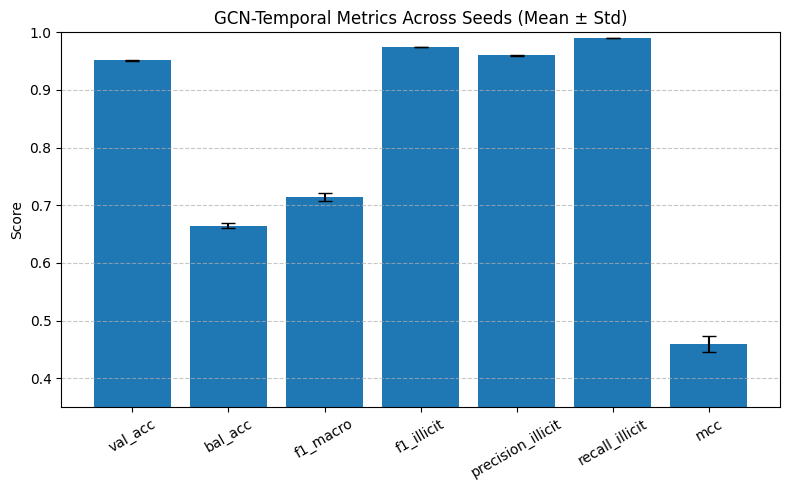

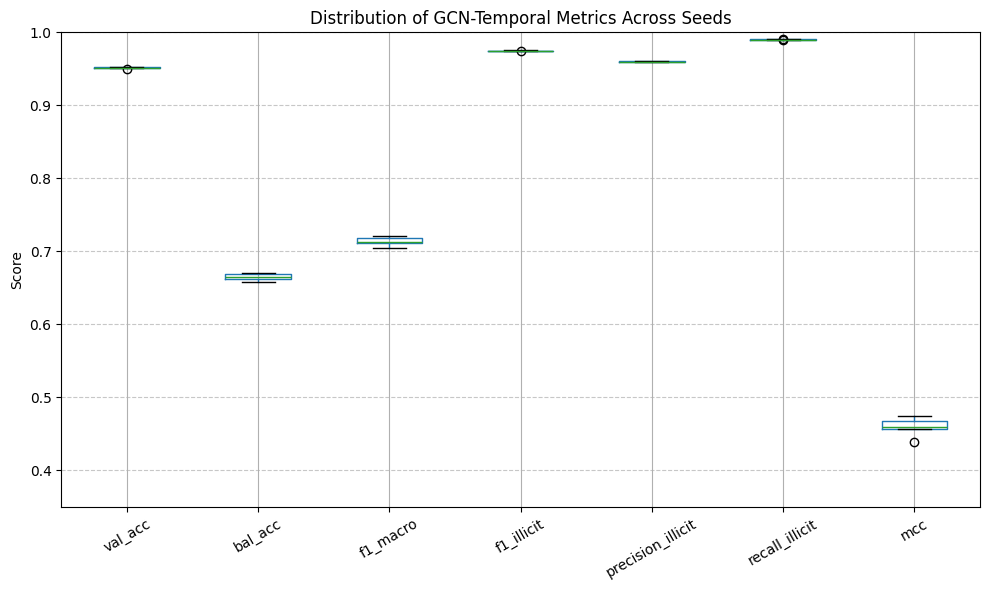

,Metric,Mean,Std,Formatted
0,val_acc,0.9518,0.0011,0.9518 ± 0.0011
1,bal_acc,0.6648,0.0051,0.6648 ± 0.0051
2,f1_macro,0.7139,0.0065,0.7139 ± 0.0065
3,f1_illicit,0.9748,0.0006,0.9748 ± 0.0006
4,precision_illicit,0.9600,0.0006,0.9600 ± 0.0006
5,recall_illicit,0.9900,0.0006,0.9900 ± 0.0006
6,mcc,0.4594,0.0135,0.4594 ± 0.0135


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Inject val_acc again safely
val_acc_list = metrics_logs["val_acc"]
for i in range(len(seed_metrics)):
    seed_metrics[i]["val_acc"] = val_acc_list[i]

# Rebuild clean DataFrame from scratch
df = pd.DataFrame(seed_metrics)

# Print once to verify
print("Final columns:", df.columns.tolist())

# Define metrics and force presence
main_metrics = ['val_acc', 'bal_acc', 'f1_macro', 'f1_illicit',
                'precision_illicit', 'recall_illicit', 'mcc']

# Select only those metrics (safely)
df = df.loc[:, df.columns.intersection(main_metrics)].copy()
df = df[main_metrics]  # enforce order
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Mean ± Std
means = df.mean()
stds = df.std()

# Bar Plot
plt.figure(figsize=(8, 5))
plt.bar(df.columns, means, yerr=stds, capsize=5)
plt.ylim(0.35, 1.0)
plt.title(f"{model_name} Metrics Across Seeds (Mean ± Std)")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
df.boxplot(showfliers=True)
plt.ylim(0.35, 1.0)
plt.title(f"Distribution of {model_name} Metrics Across Seeds")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Summary Table
summary_table = pd.DataFrame({
    "Metric": main_metrics,
    "Mean": means.round(4).values,
    "Std": stds.round(4).values,
    "Formatted": [f"{m:.4f} ± {s:.4f}" for m, s in zip(means, stds)]
})

display(summary_table)


### 5.6 Class Wise Report

In [8]:
summarize_classification_report(y_true_all, y_pred_all)



Legit (0) Metrics:
precision: 0.6803 ± 0.0159
recall: 0.3396 ± 0.0087
f1-score: 0.4531 ± 0.0111

Illicit (1) Metrics:
precision: 0.9600 ± 0.0005
recall: 0.9900 ± 0.0005
f1-score: 0.9748 ± 0.0005


### 5.7 Save FP/FN 

In [9]:
save_fp_fn_indices(y_true_all, y_pred_all, seeds, model_dir)

### 5.8 Timestamps FP/FN (Raw and Normalised)

In [10]:
data = attach_node_times(data, "../elliptic_bitcoin_dataset/elliptic_txs_features.csv")

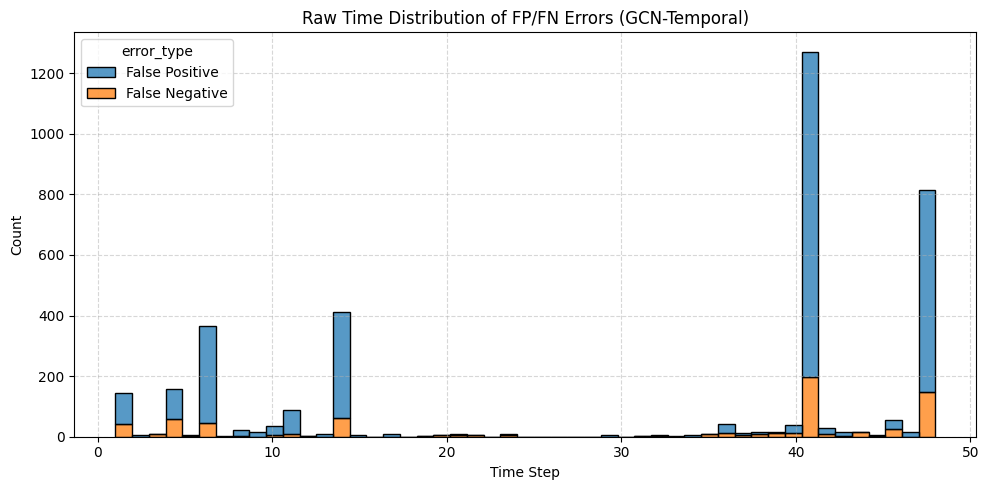

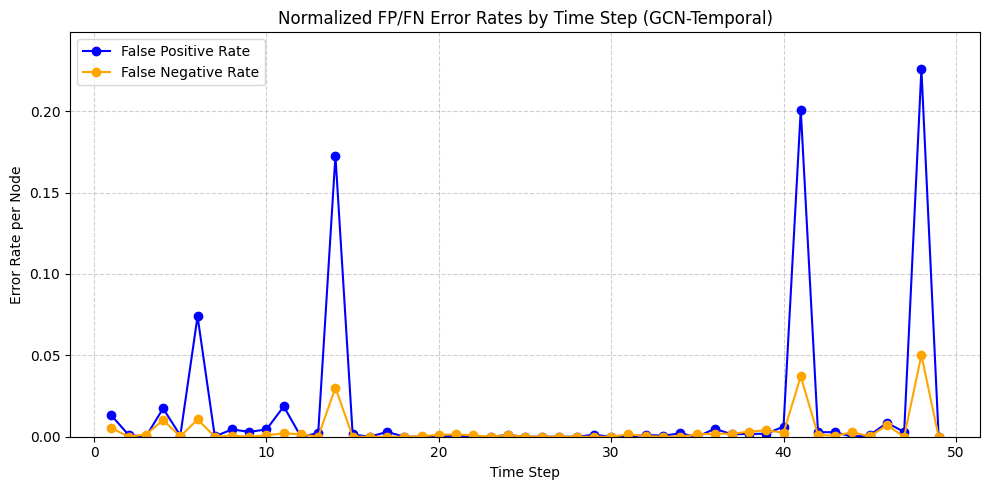

In [11]:
plot_fp_fn_time_distributions(data, seeds, model_dir, model_name=model_name)

## 6. Save data into JSON

In [12]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from evaluation_pipeline import export_full_evaluation_to_json

# --------------------------------------------
# Reconstruct confusion matrices (per seed)
# --------------------------------------------
conf_matrices = [
    confusion_matrix(y_true_all[i], y_pred_all[i])
    for i in range(len(seeds))
]

# --------------------------------------------
# Reconstruct FP/FN counts + time distributions
# using saved indices and timestamps
# --------------------------------------------
model_dir = "../model_temporal/GCN"  # <-- change per model
fp_counts, fn_counts = [], []
fp_time_all, fn_time_all = [], []

timestamps = data.node_times.cpu().numpy()

for seed in seeds:
    base = os.path.join(model_dir, f"seed_{seed}")
    fp_idx = np.load(os.path.join(base, "fp_indices.npy"))
    fn_idx = np.load(os.path.join(base, "fn_indices.npy"))

    fp_counts.append(len(fp_idx))
    fn_counts.append(len(fn_idx))

    fp_time_all.extend(timestamps[fp_idx])
    fn_time_all.extend(timestamps[fn_idx])

# Convert to JSON-compatible native Python types
fp_time_all = [int(t) for t in fp_time_all]
fn_time_all = [int(t) for t in fn_time_all]

# --------------------------------------------
# Final export to JSON files
# --------------------------------------------
export_full_evaluation_to_json(
    seed_metrics=seed_metrics,
    conf_matrices=conf_matrices,
    fp_counts=fp_counts,
    fn_counts=fn_counts,
    fp_time_all=fp_time_all,
    fn_time_all=fn_time_all,
    output_dir=model_dir
)
